In [2]:
#A normal binary tree to price vanilla option
import numpy as np
class price_node:
    def __init__(self, step, S ,K,cp='call',ae='European'):
        self.step = step
        self.S = S
        self.value = max(S-K,0) if cp=='call' else max(K-S,0)
        self.left = None
        self.right = None    
    def __repr__(self):
        return str('step:'+str(self.step)+'     S:'+str(self.S)+'   value:'+str(self.value))
    
class binomial_tree:
    #this is not most effecient way to generate tree, recurvise by brother node is better
    def __init__(self, sigma = 0.1, r = 0.05, S0 = 10, K = 12, T = 3, dt =0.5,cp='call',ae='European'):
        self.n=int(T/dt)#terminal step
        self.root = price_node(0,S0,K)
        self.r=r;self.sigma=sigma
        self.S0=S0;self.K=K
        self.T=T;self.dt=dt
        self.u=np.exp(sigma*dt**0.5) ;self.d=np.exp(-sigma*dt**0.5)
        self.p=(np.exp(r*dt)-self.d)/(self.u-self.d)
        self.value=0
        self.n=int(T/dt)
        self.cp=cp
        self.ae=ae
        self.generate_tree(self.root)
    
    def generate_tree(self,node):
        if node.step==self.n:
            node.value=max(node.S-self.K,0) if self.cp=='call' else max(self.K-node.S,0)
        else:
            node.left=price_node(node.step+1,node.S*self.u,self.K,cp=self.cp,ae=self.ae)
            node.right=price_node(node.step+1,node.S*self.d,self.K,cp=self.cp,ae=self.ae)
            self.generate_tree(node.left)
            self.generate_tree(node.right)
            if self.ae=='European':
                node.value=np.exp(-self.r*self.dt)*(self.p*node.left.value+(1-self.p)*node.right.value)
            else:
                node.value=max(np.exp(-self.r*self.dt)*(self.p*node.left.value+(1-self.p)*node.right.value), node.value)    

    def print_tree(self,node):
        if node is None:
            return
        print(node)
        self.print_tree(node.left)
        self.print_tree(node.right)



In [3]:
tree=binomial_tree(S0=29,K=30,T=1,dt=0.5,sigma=0.25,r=0.03,cp='put',ae='European')   
tree.print_tree(tree.root)

step:0     S:29   value:2.83771598784725
step:1     S:34.60757280399054   value:0.4940878867328611
step:2     S:41.29945156494848   value:0
step:2     S:29.000000000000004   value:0.9999999999999964
step:1     S:24.301039681783916   value:5.252318506307964
step:2     S:29.0   value:1.0
step:2     S:20.363466538470227   value:9.636533461529773


In [4]:
tree=binomial_tree(S0=29,K=30,T=1,dt=0.5,sigma=0.25,r=0.03,cp='put',ae='American')   
tree.print_tree(tree.root)

step:0     S:29   value:3.05839629681947
step:1     S:34.60757280399054   value:0.4940878867328611
step:2     S:41.29945156494848   value:0
step:2     S:29.000000000000004   value:0.9999999999999964
step:1     S:24.301039681783916   value:5.698960318216084
step:2     S:29.0   value:1.0
step:2     S:20.363466538470227   value:9.636533461529773


Cheuk-Vorst is another way to calculate American option price, and it only uses half of the tree.

Trinomial schemes:
$$V=\frac{p_1V_u^{\Delta t}+p_2V_u^{\Delta t}+p_3V_u^{\Delta t}}{e^{r\Delta t}}$$
$$p1=\frac{1}{\lambda^2}+\frac{(r-\frac{\sigma^2}{2}) \sqrt{\Delta t}}{2\lambda\sigma}$$
$$p2=1-\frac{1}{\lambda^2}$$
$$p3=\frac{1}{\lambda^2}-\frac{(r-\frac{\sigma^2}{2}) \sqrt{\Delta t}}{2\lambda\sigma}$$

our experience is that $\lambda=\sqrt{3}$ is the best

Multistate extension- Kamrad-Ritchken's Approach($\lambda>=1$ is a free parameter)

$$p1(s1u,s2u)=\frac{1}{4}(\frac{1}{\lambda^2}+\frac{\sqrt{\Delta t}}{\lambda}(\frac{r-\frac{\sigma^2_1}{2}}{\sigma_1}+\frac{r-\frac{\sigma^2_2}{2}}{\sigma_2})+\frac{\rho}{\lambda^2})$$
$$p2(s1u,s2d)=\frac{1}{4}(\frac{1}{\lambda^2}+\frac{\sqrt{\Delta t}}{\lambda}(\frac{r-\frac{\sigma^2_1}{2}}{\sigma_1}-\frac{r-\frac{\sigma^2_2}{2}}{\sigma_2})-\frac{\rho}{\lambda^2})$$
$$p3(s1d,s2d)=\frac{1}{4}(\frac{1}{\lambda^2}+\frac{\sqrt{\Delta t}}{\lambda}(-\frac{r-\frac{\sigma^2_1}{2}}{\sigma_1}-\frac{r-\frac{\sigma^2_2}{2}}{\sigma_2})+\frac{\rho}{\lambda^2})$$
$$p4(s1d,s2u)=\frac{1}{4}(\frac{1}{\lambda^2}+\frac{\sqrt{\Delta t}}{\lambda}(-\frac{r-\frac{\sigma^2_1}{2}}{\sigma_1}+\frac{r-\frac{\sigma^2_2}{2}}{\sigma_2})-\frac{\rho}{\lambda^2})$$
$$p5(s1h,s2h)=1-\frac{1}{\lambda^2}$$

Forward shooting grid methods(path dependent options)

The approach of appending au auxiliary state vector at each node in the lattice tree to model the correlated evolution of $F_t$ with $S_t$ is commonly called the FSG method. path dependent function:
$$F_{t+\Delta t}=G(F_t,t,S_{t+\Delta t})$$

Let $g(k,n,j)$ denote the grid function which is considered as the discrete analog of the evolution function G, here K is the index for $F_t$,n is the index for t and j is the index for $S_{t+\Delta t}$

The trinomial version of FSG scheme can be represented as:
$$V^n_{j,k}=[p_uV^{n+1}_{j+1,g(k,n,j+1)} + p_0V^{n+1}_{j,g(k,n,j)}+ p_dV^{n+1}_{j-1,g(k,n,j-1)}]e^{-r \Delta t}$$

In [ ]:
#Below is a complex structure product, and we use tree to price it 
#It is a combination of several products, 1.a FCN 2. Accrual Note(After first coupon pyament) 3.Issuer Call 

In [3]:
%load_ext Cython

rho:	 -0.9 	price:	 1029385.7356768153
rho:	 -0.6000000000000001 	price:	 1028986.5988797316
rho:	 -0.30000000000000004 	price:	 1028615.1997564037
rho:	 -1.1102230246251565e-16 	price:	 1028455.6284152514
rho:	 0.29999999999999993 	price:	 1028629.7734572819
rho:	 0.6 	price:	 1029264.9708140693
rho:	 0.9 	price:	 1030786.320042197
sigma:	 0.1 	price:	 1030786.320042197
sigma:	 0.24000000000000002 	price:	 956298.4400968611
sigma:	 0.38 	price:	 864854.0869841902
sigma:	 0.52 	price:	 775445.5137522606
sigma:	 0.66 	price:	 689742.976641749
sigma:	 0.8 	price:	 611762.6660613195
r:	 0.01 	price:	 621964.6597574964
r:	 0.04 	price:	 606548.6415930372
r:	 0.07 	price:	 590496.478587635
r:	 0.1 	price:	 573875.7212761545


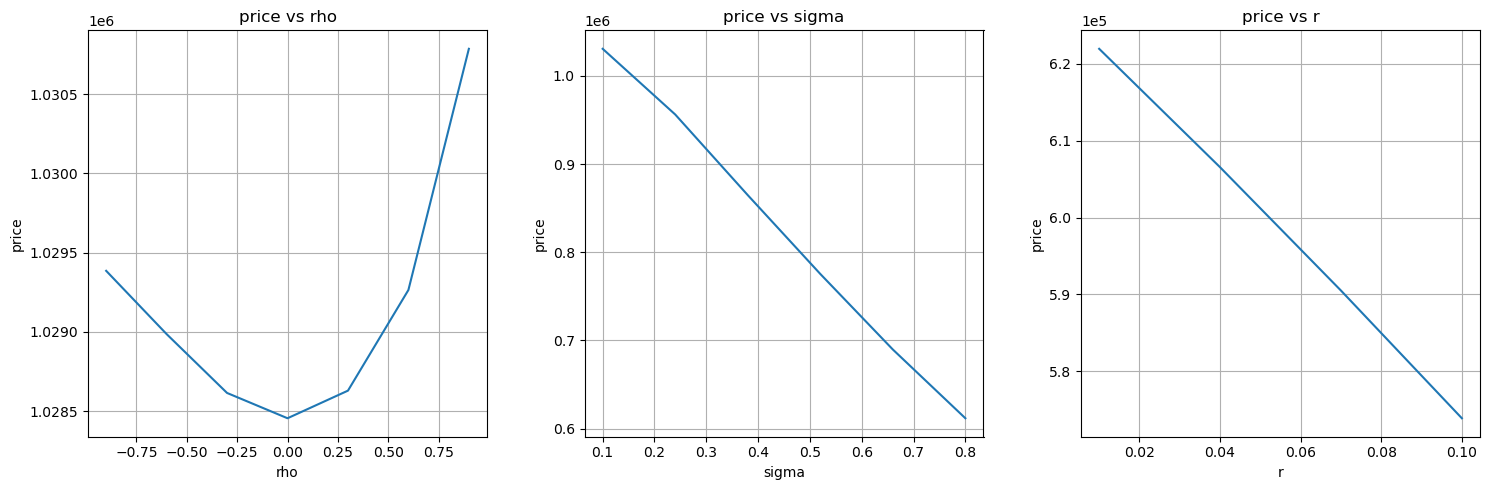

In [84]:
%%cython 
import numpy as np
cimport numpy as np
from libc.math cimport round
from libc.math cimport exp
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

para_dic={'r':0.03, 'sigma1':0.1, 'sigma2':0.1,'rho':0.1,'lambda':3**0.5 ,'K':0.87, 'T':2, 'dt':1/252,'ob_day':63,'notion':1_000_000,'coupon_rate':0.04075}
para_dic['n']=int(para_dic['T']/para_dic['dt'])

def update_para(para_dic,**kwargs):
    para_dic.update(kwargs)
    return para_dic


cdef double tree_price(dict para_dic):
    cdef double r=para_dic['r'],sigma1=para_dic['sigma1'],sigma2=para_dic['sigma2'],rho=para_dic['rho'],\
    lambda_=para_dic['lambda'],K=para_dic['K'],T=para_dic['T'],dt=para_dic['dt'],notion=para_dic['notion'],\
    coupon_rate=para_dic['coupon_rate']
    cdef int ob_day=para_dic['ob_day'],n=para_dic['n'],t,i,j,term
    
    
    cdef double puu=0.25*(1/lambda_**2+dt**0.5/lambda_*((r-sigma1**2/2)/sigma1+(r-sigma2**2/2)/sigma2)+rho/lambda_**2)
    cdef double pud=0.25*(1/lambda_**2+dt**0.5/lambda_*((r-sigma1**2/2)/sigma1-(r-sigma2**2/2)/sigma2)-rho/lambda_**2)
    cdef double pdd=0.25*(1/lambda_**2+dt**0.5/lambda_*(-(r-sigma1**2/2)/sigma1-(r-sigma2**2/2)/sigma2)+rho/lambda_**2)
    cdef double pdu=0.25*(1/lambda_**2+dt**0.5/lambda_*(-(r-sigma1**2/2)/sigma1+(r-sigma2**2/2)/sigma2)-rho/lambda_**2)
    cdef double phh=1-1/lambda_**2
    cdef double u1=exp(lambda_*sigma1*dt**0.5)
    cdef double u2=exp(lambda_*sigma2*dt**0.5)
    cdef double coupon=coupon_rate*dt*notion
    
    cdef np.ndarray result = np.zeros([para_dic['n']+1,(2*para_dic['n']+1)**2], dtype=np.float64)
    cdef double[:,:] array= result
    
    for t in range(n+1):
        term=n-t
        for i in range(-term,term+1): #the absolute of (upward times - downward times) of S1
            for j in range(-term,term+1): #the absolute of (upward times - downward times) of S2
                if term==n:
                    array[term, (i+term)*(2*term+1 )+(j+term)]=(1-max(1-min(u1**(i)/K\
                                                ,u2**(j)/K),0))*notion\
                                                    +coupon*ob_day
                elif term==63:
                    array[term,(i+term)*(2*term+1 )+(j+term)]=exp(-r*dt)*\
                        (puu*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1+1)]+\
                            pud*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1-1)]+\
                                pdu*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1+1)]+\
                                    pdd*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1-1)]+\
                                        phh*array[term+1,(i+term+1)*(2*term+1+2)+(j+term+1)])+\
                                            4*ob_day*coupon
                                            
                elif term<63:                    
                    array[term,(i+term)*(2*term+1 )+(j+term)]=exp(-r*dt)*\
                        (puu*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1+1)]+\
                            pud*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1-1)]+\
                                pdu*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1+1)]+\
                                    pdd*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1-1)]+\
                                        phh*array[term+1,(i+term+1)*(2*term+1+2)+(j+term+1)])
                                                        
                elif term%ob_day==0: 
                    W_cont=exp(-r*dt)*\
                        (puu*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1+1)]+\
                            pud*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1-1)]+\
                                pdu*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1+1)]+\
                                    pdd*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1-1)]+\
                                        phh*array[term+1,(i+term+1)*(2*term+1+2)+(j+term+1)])+\
                                            coupon*(min(u1**(i)/K,u2**(j)/K)>1)*exp(-r*dt*ob_day)
                    array[term,(i+term)*(2*term+1 )+(j+term)] = min(W_cont,notion)
                    
                else:
                    array[term,(i+term)*(2*term+1 )+(j+term)]=exp(-r*dt)*\
                        (puu*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1+1)]+\
                            pud*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1-1)]+\
                                pdu*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1+1)]+\
                                    pdd*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1-1)]+\
                                        phh*array[term+1,(i+term+1)*(2*term+1+2)+(j+term+1)])+\
                                            coupon*(min(u1**(i)/K,u2**(j)/K)>1)*exp(-r*dt*(ob_day-term%ob_day))
    
    return result[0,0]

rho_list=np.linspace(-0.9,0.9,7)
sigma_list=np.linspace(0.1,0.8,6)
r_list=np.linspace(0.01,0.1,4)


# price_list_rho=Parallel(n_jobs=16)(delayed(tree_price)(update_para(para_dic,rho=rho)) for rho in rho_list)
# price_list_sigma=Parallel(n_jobs=16)(delayed(tree_price)(update_para(para_dic,sigma1=sigma,sigma2=sigma)) for sigma in sigma_list)
# price_list_r=Parallel(n_jobs=16)(delayed(tree_price)(update_para(para_dic,r=r)) for r in r_list)

price_list_rho=[tree_price(update_para(para_dic,rho=rho)) for rho in rho_list]
price_list_sigma=[tree_price(update_para(para_dic,sigma1=sigma,sigma2=sigma)) for sigma in sigma_list]
price_list_r=[tree_price(update_para(para_dic,r=r)) for r in r_list]

[print('rho:\t',rho_list[i],'\tprice:\t' ,price) for i,price in enumerate(price_list_rho)]
[print('sigma:\t',sigma_list[i],'\tprice:\t' ,price) for i,price in enumerate(price_list_sigma)]
[print('r:\t',r_list[i],'\tprice:\t' ,price) for i,price in enumerate(price_list_r)]


fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].ticklabel_format(useOffset=False)
ax[0].plot(rho_list,price_list_rho)
ax[0].set_xlabel('rho')
ax[0].set_ylabel('price')
ax[0].set_title('price vs rho')
ax[0].grid()
ax[1].plot(sigma_list,price_list_sigma)
ax[1].ticklabel_format(useOffset=False)
ax[1].set_xlabel('sigma')
ax[1].set_ylabel('price')
ax[1].set_title('price vs sigma')
ax[1].grid()
ax[2].plot(r_list,price_list_r)
ax[2].ticklabel_format(useOffset=False)
ax[2].set_xlabel('r')
ax[2].set_ylabel('price')
ax[2].set_title('price vs r')
ax[2].grid()
plt.tight_layout()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#the second and third plot shows the appropriate range of sigma and r, as the sigma and r increase, the price decrease.
#1. higher sigma leads to higher volatility, which means the price of the underlying asset is more likely to be far away from the strike price
#2. higher r leads to higher interest rate, which means the discounted factor is higher, so the price is lower
#3. however, the first plot is against our intuition, which is that correlation increases, the price increases.
#So we continue to plot a 3D plot to see the relationship between price with sigma and rho

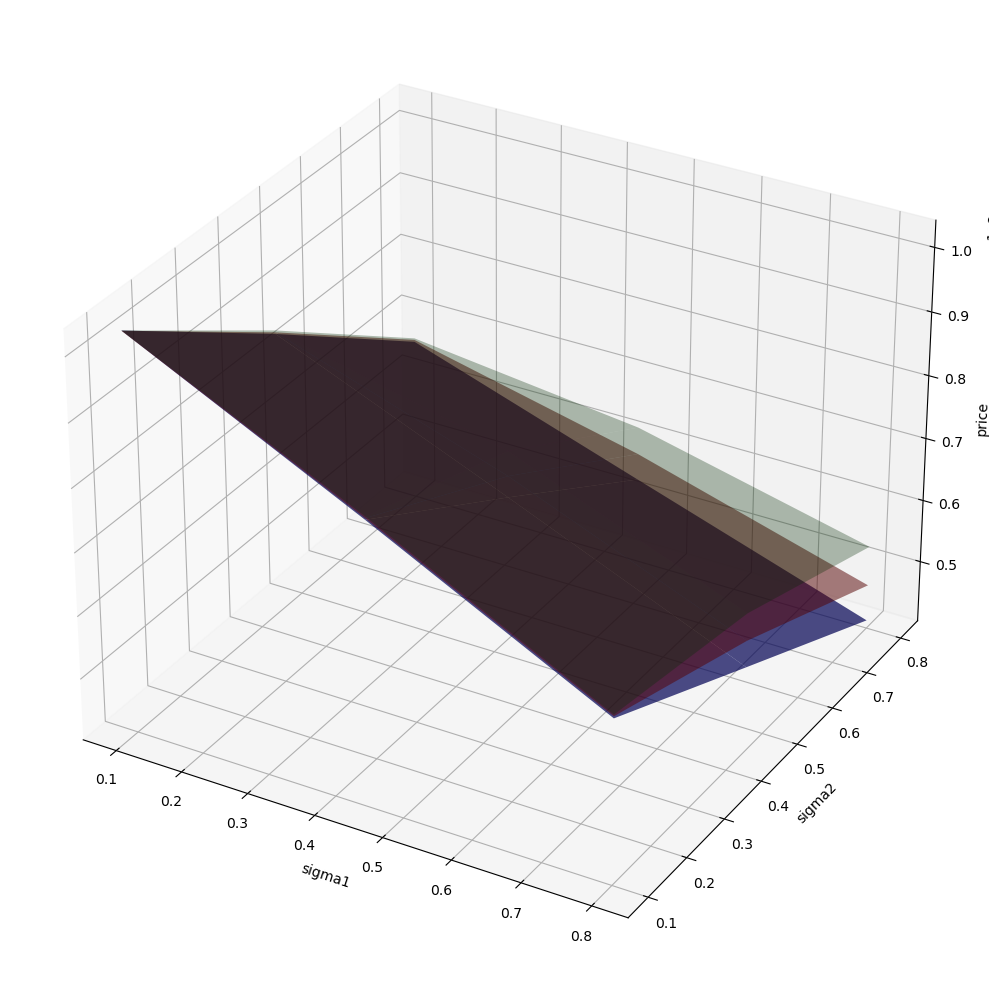

In [4]:
%%cython 
import numpy as np
cimport numpy as np
from libc.math cimport round
from libc.math cimport exp
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from itertools import product
from mpl_toolkits.mplot3d import Axes3D

para_dic={'r':0.03, 'sigma1':0.1, 'sigma2':0.1,'rho':0.1,'lambda':3**0.5 ,'K':0.87, 'T':2, 'dt':1/252,'ob_day':63,'notion':1_000_000,'coupon_rate':0.04075}
para_dic['n']=int(para_dic['T']/para_dic['dt'])

def update_para(para_dic,**kwargs):
    para_dic.update(kwargs)
    return para_dic


cdef double tree_price(dict para_dic):
    cdef double r=para_dic['r'],sigma1=para_dic['sigma1'],sigma2=para_dic['sigma2'],rho=para_dic['rho'],\
    lambda_=para_dic['lambda'],K=para_dic['K'],T=para_dic['T'],dt=para_dic['dt'],notion=para_dic['notion'],\
    coupon_rate=para_dic['coupon_rate']
    cdef int ob_day=para_dic['ob_day'],n=para_dic['n'],t,i,j,term
    
    
    cdef double puu=0.25*(1/lambda_**2+dt**0.5/lambda_*((r-sigma1**2/2)/sigma1+(r-sigma2**2/2)/sigma2)+rho/lambda_**2)
    cdef double pud=0.25*(1/lambda_**2+dt**0.5/lambda_*((r-sigma1**2/2)/sigma1-(r-sigma2**2/2)/sigma2)-rho/lambda_**2)
    cdef double pdd=0.25*(1/lambda_**2+dt**0.5/lambda_*(-(r-sigma1**2/2)/sigma1-(r-sigma2**2/2)/sigma2)+rho/lambda_**2)
    cdef double pdu=0.25*(1/lambda_**2+dt**0.5/lambda_*(-(r-sigma1**2/2)/sigma1+(r-sigma2**2/2)/sigma2)-rho/lambda_**2)
    cdef double phh=1-1/lambda_**2
    cdef double u1=exp(lambda_*sigma1*dt**0.5)
    cdef double u2=exp(lambda_*sigma2*dt**0.5)
    cdef double coupon=coupon_rate*dt*notion
    
    cdef np.ndarray result = np.zeros([para_dic['n']+1,(2*para_dic['n']+1)**2], dtype=np.float64)
    cdef double[:,:] array= result
    
    for t in range(n+1):
        term=n-t
        for i in range(-term,term+1): #the absolute of (upward times - downward times) of S1
            for j in range(-term,term+1): #the absolute of (upward times - downward times) of S2
                if term==n:
                    array[term, (i+term)*(2*term+1 )+(j+term)]=(1-max(1-min(u1**(i)/K\
                                                ,u2**(j)/K),0))*notion\
                                                    +coupon*ob_day
                elif term==63:
                    array[term,(i+term)*(2*term+1 )+(j+term)]=exp(-r*dt)*\
                        (puu*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1+1)]+\
                            pud*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1-1)]+\
                                pdu*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1+1)]+\
                                    pdd*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1-1)]+\
                                        phh*array[term+1,(i+term+1)*(2*term+1+2)+(j+term+1)])+\
                                            4*ob_day*coupon
                                            
                elif term<63:                    
                    array[term,(i+term)*(2*term+1 )+(j+term)]=exp(-r*dt)*\
                        (puu*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1+1)]+\
                            pud*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1-1)]+\
                                pdu*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1+1)]+\
                                    pdd*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1-1)]+\
                                        phh*array[term+1,(i+term+1)*(2*term+1+2)+(j+term+1)])
                                                        
                elif term%ob_day==0: 
                    W_cont=exp(-r*dt)*\
                        (puu*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1+1)]+\
                            pud*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1-1)]+\
                                pdu*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1+1)]+\
                                    pdd*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1-1)]+\
                                        phh*array[term+1,(i+term+1)*(2*term+1+2)+(j+term+1)])+\
                                            coupon*(min(u1**(i)/K,u2**(j)/K)>1)*exp(-r*dt*ob_day)
                    array[term,(i+term)*(2*term+1 )+(j+term)] = min(W_cont,notion)
                    
                else:
                    array[term,(i+term)*(2*term+1 )+(j+term)]=exp(-r*dt)*\
                        (puu*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1+1)]+\
                            pud*array[term+1,(i+term+1+1)*(2*term+1+2)+(j+term+1-1)]+\
                                pdu*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1+1)]+\
                                    pdd*array[term+1,(i+term+1-1)*(2*term+1+2)+(j+term+1-1)]+\
                                        phh*array[term+1,(i+term+1)*(2*term+1+2)+(j+term+1)])+\
                                            coupon*(min(u1**(i)/K,u2**(j)/K)>1)*exp(-r*dt*(ob_day-term%ob_day))
    
    return result[0,0]

sigma_list=np.linspace(0.1,0.8,3)
product_list=list(product(sigma_list,sigma_list))
price_list_sigma_pho_05=[tree_price(update_para(para_dic,sigma1=sigma1,sigma2=sigma2,rho=0.5)) for sigma1,sigma2 in product_list]
price_list_sigma_pho_n05=[tree_price(update_para(para_dic,sigma1=sigma1,sigma2=sigma2,rho=-0.5)) for sigma1,sigma2 in product_list]
price_list_sigma_pho_0=[tree_price(update_para(para_dic,sigma1=sigma1,sigma2=sigma2,rho=0)) for sigma1,sigma2 in product_list]

X,Y=np.meshgrid(sigma_list,sigma_list)
Z1=np.array(price_list_sigma_pho_05).reshape(3,3).T
Z2=np.array(price_list_sigma_pho_n05).reshape(3,3).T
Z3=np.array(price_list_sigma_pho_0).reshape(3,3).T

fig=plt.figure(figsize=(10,15))
ax3=plt.axes(projection='3d')
ax3.set_xlabel('sigma1')
ax3.set_ylabel('sigma2')
ax3.set_zlabel('price')
ax3.plot_surface(X,Y,Z1,edgecolor='none',color='g',alpha=0.3,label='rho=0.5')
ax3.plot_surface(X,Y,Z2,edgecolor='none',color='b',alpha=0.7,label='rho=-0.5')
ax3.plot_surface(X,Y,Z3,edgecolor='none',color='r',alpha=0.5,label='rho=0')
# The fix
for spine in ax3.spines.values():
    spine.set_visible(False)

plt.tight_layout()

#as we can see from the graph, the price of the product is decreasing with the increase of sigma1 and sigma2
#besides, high correlation between two assets will lead to a higher price

#notice when sigma1=sigma2=0.1, the price with different correlation is almost the same,
#and this can well explain the unmonotonic relationship in the first figure is not an error.
#it is just beacuse the sigma1 and sigma2 are too small to affect the price so show the unmonotonic relationship
#when sigmas are big enough, as the rho increase, the price will decrease significantly

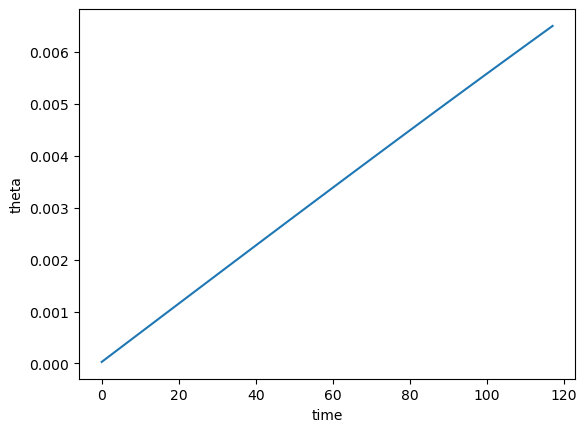

4.620399298192315


In [4]:
#ho-lee tree model
import numpy as np
import matplotlib.pyplot as plt
#discounted curve
discount_curve=lambda dt,n: (1+0.05*dt)**(-n)
dt=0.25
T=30
sigma=0.015
n=int(T/dt)
discount_list=[discount_curve(dt,i) for i in range(1,n+1)]
r=np.zeros((n-1,n-1),dtype=np.float64)
Q=np.zeros((n-1,n-1),dtype=np.float64)#arrow-security price
th=np.zeros((n-2,1),dtype=np.float64)
srdt=sigma*np.sqrt(dt)
r0=-np.log(discount_list[0])/dt

Q[0,0]=1
r[0,0]=r0
for i in range(1,n-1):
    Q[i,0]=0.5*np.exp(-r[i-1,0]*dt)*Q[i-1,0]
    for j in range(1,i):
        Q[i,j]=0.5*np.exp(-r[i-1,j-1]*dt)*Q[i-1,j-1]+0.5*np.exp(-r[i-1,j]*dt)*Q[i-1,j]
    Q[i,i]=0.5*np.exp(-r[i-1,i-1]*dt)*Q[i-1,i-1]
    
    r[i,0]=r[i-1,0]-srdt
    sumQ=Q[i,0]*np.exp(-r[i,0]*dt)
    for j in range(1,i+1):
        r[i,j]=r[i,j-1]+2*srdt
        sumQ+=Q[i,j]*np.exp(-r[i,j]*dt)
    sumQ=sumQ/discount_list[i]
    th[i-1]=np.log(sumQ)/dt**2
    for j in range(0,i+1):
        r[i,j]=r[i,j]+th[i-1]*dt

plt.xlabel('time')
plt.ylabel('theta')
plt.plot(th)
plt.show()

terminal_t=9.5
exercise_t=5
terminal_n=int(terminal_t/dt)
exercise_n=int(exercise_t/dt)
coupon_rate=0.0525
bond_path=np.zeros((terminal_n+1,terminal_n+1),dtype=np.float64)
option_path=np.zeros((exercise_n+1,exercise_n+1),dtype=np.float64)

for i in range(0,terminal_n+1):
    term=terminal_n-i
    for j in range(0,term+1):
        if term==terminal_n:
            bond_path[term,j]=100
        elif (term+1)%(0.5/dt)==0:
            bond_path[term,j]=0.5*(bond_path[term+1,j]+bond_path[term+1,j+1]+2*coupon_rate*0.5*100)/np.exp(r[term,j]*dt)
        else:
            bond_path[term,j]=0.5*(bond_path[term+1,j]+bond_path[term+1,j+1])/np.exp(r[term,j]*dt)

for i in range(0,exercise_n+1):
    term=exercise_n-i
    for j in range(0,term+1):
        if term==exercise_n:
            option_path[term,j]=max(0,bond_path[term,j]-100)
        else:
            option_path[term,j]=(option_path[term+1,j]*(0.5)+option_path[term+1,j+1]*(0.5))*np.exp(-r[term,j]*dt)

print(option_path[0,0])

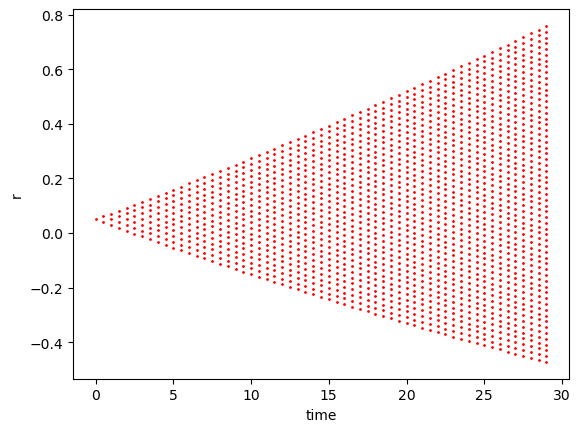

In [31]:
for i in range(0,n-1):
    for j in range(0,i+1):
        x=i*0.5
        y=r[i,j]
        plt.plot(x,y,'ro',markersize=1)
plt.ylabel('r')
plt.xlabel('time')
plt.show()

Alpha quantile option: trinomial tree pricing
---

$$B_{inf}(T;\alpha)=inf  \left\{B: \frac{1}{T} \int^{T}_{0}\mathbb{1}_{\left\{  {S_t}\leqslant B \right\}} dt\geq \alpha    \right\} $$

$$ V_{\alpha}(S,T)=max(B_{inf}(T;\alpha)-X,0 )$$
$$ V_{\alpha}(S,0)=e^{-rT} \sum^N_{j=-N}P \left[B_{inf}=S_j\right] max(S_j-X,0),\ S_j=S_0u^j,\  where \ j=-N,... N-1$$

let $V^{bin}_{cum}(\alpha, B)$ denote the value of a binary option that pays \$1 at maturity T if the cumulative staying at or below the down-barrier B is less than $\alpha $ of the total life of the option, $0 \leq \alpha \leq 1$; otherwise 0. Option price is equivalent to the state price of such an event:
$$ \frac{1}{T} \int^{T}_{0}\mathbb{1}_{\left\{  {S_t}\leqslant B \right\}} dt < \alpha   $$

$$ whith\ a\ given\ B: \ V^{bin}_{cum}(\alpha, S_j)=e^{-rT}P   \left[ B_{inf}>S_j \right]   $$ 
$$e^{-rT}P   \left[ B_{inf}=S_j \right]  =e^{-rT} \left\{   P\left[   B_{inf}> S_{j-1}\right] - P\left[B_{inf}> S_{j} \right] \right\} $$
$$=V^{bin}_{cum}(\alpha, S_{j-1})-V^{bin}_{cum}(\alpha, S_j)$$

$$V^N_{j,k} = \begin{cases}
1, & \text{if }  \leq k\leq <\alpha N  ; \\
0, & \text{if } k\geq \alpha N.
\end{cases}$$
$$\ where\ k\ counts\ the\ number\ of\ time\ steps\ in\ the\ total\ number\ of\ N\ time\ steps\ $$
$$that\ S^n_j\leq B\ and\ N\ is\ the\ total\ steps\ in\ the\ lattice\ tree\ calculations
$$

In [ ]:
import numpy as np
alhpa=0.8;S=100;X=95;r=0.05;q=0;sigma=0.2;T=0.25;dt=0.01
n=int(T/dt)

lambda_=3**0.5
p1=1/(2*lambda_**2)+(r-sigma**2/2)*dt**0.5/(2*lambda_*sigma)
p2=1-1/lambda_**2
p3=1/(2*lambda_**2)-(r-sigma**2/2)*dt**0.5/(2*lambda_*sigma)


Leveraged  Accumulator Pricing
-----
1. forward shooting grid technique
$$G(k,i)=k+2000\ \mathbb{1}_{\left\{i<I_{strike}\right\}}+1000\ \mathbb{1}_{\left\{i\geq I_{strike}\right\}}      $$

$$usual\ binomial\ scheme:\ V(j,l,i,k)=e^{-r\Delta t}  \left[pV(j,l+1,i+1,k)+(1-p)V(j,l+1,i-1,k)  \right]  $$
$$at\ time\ step\ corresponding\ to\ stock\ accumulation:\$$
$$ V(j,l,i,k)=e^{-r\Delta t} \left[pV(j,l+1,i+1,G(k,i+1)) +(1-p)V(j,l+1,i-1,G(k,i-1))\right] $$

$j$ is the accumulation period.

$l$ denote the number of time steps lapsed from the last settlement date.$j$ is the accumulation period

$i$ is the stock price index 

$k$ is shares accumulated(path dependent)

2. Jump conditions are applied across each settlement date(ending date of an accumulation period)
$$V(j,m*l_{max(j)},i,k)=V(j+1,0,i,0)+k(S_i-Xe^{-rM\Delta t})$$